In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl 
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', -1)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

mpl.rcParams['figure.dpi'] = 100
%matplotlib inline

In [2]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, f1_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV, cross_val_score
from joblib import parallel_backend

In [3]:
def under_sample(data_df, class_col, random_state=42):
    value_counts = data_df[class_col].value_counts()
    count = value_counts.min()
    df_parts = []
    for class_i in value_counts.index:
        df_parts.append(data_df[data_df[class_col] == class_i].sample(
            count, random_state=random_state))
    sample_df = pd.concat(df_parts, axis=0)
    return sample_df.sample(sample_df.shape[0], random_state=42)


def show_report(y_true, y_pred, target_names):    
    fig, ax = plt.subplots(1, figsize=(5, 5))

    mat = confusion_matrix(y_true, y_pred)
    sns.heatmap(mat, square=True, annot=True, cbar=False, ax=ax, fmt='g') 
    plt.xlabel('predicted value')
    plt.ylabel('true value');

    print(classification_report(y_true, y_pred, target_names=target_names))


def show_auc(y_true, y_pred_proba):    
    
    # roc_auc_score(y_true, y_pred_proba)

    fpr, tpr, thresholds = roc_curve(
        y_true,
        y_pred_proba,
        pos_label=1
    )
    auc_val = auc(fpr, tpr)

    fig, ax = plt.subplots(figsize=(8, 8))
    plt.plot([0, 1], [0, 1], 'k--')

    ax.plot(fpr, tpr, label=f'AUC: {auc_val:.2f}')
    ax.legend(loc=4);

In [4]:
DATA_DIR_PATH = '../classification/data/'

train_df = pd.read_csv(os.path.join(DATA_DIR_PATH, 'datasets', 'wikipedia_comments', 'train.csv.zip'))
test_df = pd.read_csv(os.path.join(DATA_DIR_PATH, 'datasets', 'wikipedia_comments', 'test.csv.zip'))
test_labels_df = pd.read_csv(os.path.join(DATA_DIR_PATH, 'datasets', 'wikipedia_comments', 'test_labels.csv.zip'))
test_df = pd.merge(test_df, test_labels_df)
test_df = test_df.query('toxic != -1')
test_undersampled_df = under_sample(test_df, 'toxic')

In [5]:
train_df.toxic.value_counts()

0    144277
1    15294 
Name: toxic, dtype: int64

In [6]:
test_df.toxic.value_counts()

0    57888
1    6090 
Name: toxic, dtype: int64

In [7]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


---

## Default model

              precision    recall  f1-score   support

   Non-Toxic       0.92      1.00      0.96     57888
       Toxic       0.81      0.18      0.29      6090

    accuracy                           0.92     63978
   macro avg       0.87      0.59      0.62     63978
weighted avg       0.91      0.92      0.89     63978



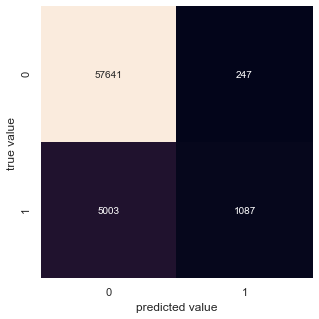

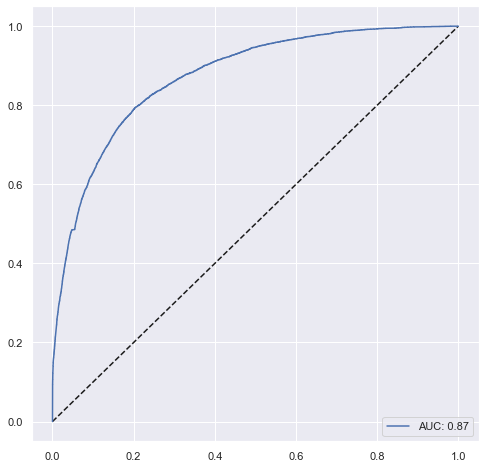

In [8]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(train_df['comment_text'], train_df['toxic'])
show_report(test_df['toxic'], model.predict(test_df['comment_text']), ['Non-Toxic', 'Toxic'])
show_auc(test_df['toxic'], model.predict_proba(test_df['comment_text'])[:, 1])

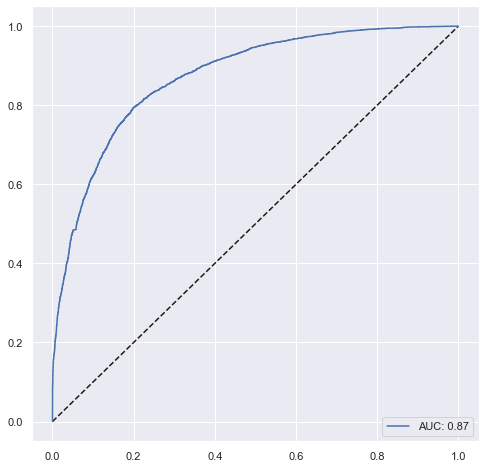

In [9]:
show_auc(test_undersampled_df['toxic'], model.predict_proba(test_undersampled_df['comment_text'])[:, 1])

              precision    recall  f1-score   support

   Non-Toxic       0.55      0.99      0.71      6090
       Toxic       0.97      0.18      0.30      6090

    accuracy                           0.59     12180
   macro avg       0.76      0.59      0.50     12180
weighted avg       0.76      0.59      0.50     12180



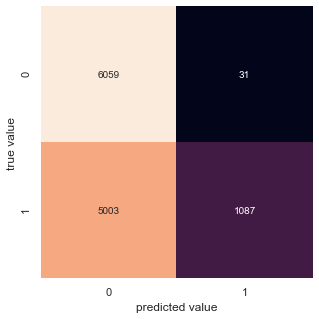

In [10]:
show_report(test_undersampled_df['toxic'], model.predict(test_undersampled_df['comment_text']), ['Non-Toxic', 'Toxic'])

## No prior

              precision    recall  f1-score   support

   Non-Toxic       0.98      0.87      0.92     57888
       Toxic       0.40      0.83      0.54      6090

    accuracy                           0.86     63978
   macro avg       0.69      0.85      0.73     63978
weighted avg       0.92      0.86      0.88     63978



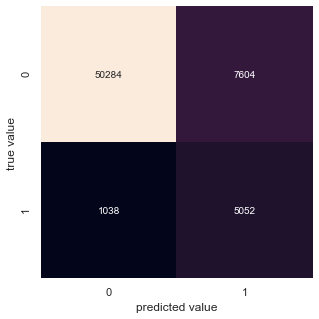

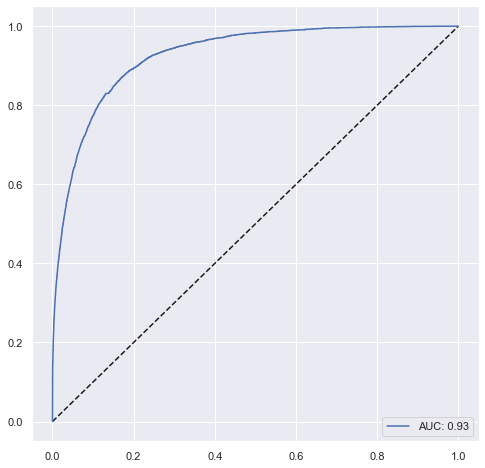

In [11]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB(alpha=0.1, class_prior=None, fit_prior=False))
model.fit(train_df['comment_text'], train_df['toxic'])
show_report(test_df['toxic'], model.predict(test_df['comment_text']), ['Non-Toxic', 'Toxic'])
show_auc(test_df['toxic'], model.predict_proba(test_df['comment_text'])[:, 1])

In [12]:
%%time
param_grid = {
    'tfidfvectorizer__max_df': [0.1, 0.5, 1],
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)], 
    'tfidfvectorizer__stop_words': [None, 'english'],
    'multinomialnb__alpha': [0.1, 0.5, 1],
    'multinomialnb__fit_prior': [True, False]
}

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

# with parallel_backend('loky'):
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', n_jobs=6, cv=5)
grid.fit(train_df['comment_text'], train_df['toxic'])

CPU times: user 58.1 s, sys: 37 s, total: 1min 35s
Wall time: 37min 6s


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidfvectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                               

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

In [ ]:
import wandb

hyperparameter_defaults = dict(
    dropout = 0.5,
    channels_one = 16,
    channels_two = 32,
    batch_size = 100,
    learning_rate = 0.001,
    epochs = 2,
    )

wandb.init(config=hyperparameter_defaults, project="delete_me")
config = wandb.config

In [ ]:
print(dict(config))

{'dropout': 0.5, 'channels_one': 16, 'channels_two': 32, 'batch_size': 100, 'learning_rate': 0.001, 'epochs': 2}


In [ ]:
precision_recall_fscore_support(y_true, y_pred)

(array([0.83669259, 0.86086069]),
 array([0.86568144, 0.83103448]),
 array([0.8509402 , 0.84568469]),
 array([6090, 6090]))

In [ ]:
accuracy_score(y_true, y_pred)

0.8483579638752052

In [ ]:
cross_val_score(model, X=train_df['comment_text'], y=train_df['toxic'])

array([0.9186276 , 0.91840572, 0.91856239, 0.91887573, 0.91821771])

In [ ]:
import joblib

joblib.dump(grid, 'grid.pickle')

['grid.pickle']

In [ ]:
grid.best_estimator_

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.5, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('multinomialnb',
                 MultinomialNB(alpha=0.1, class_prior=None, fit_prior=False))],
         verbose=False)

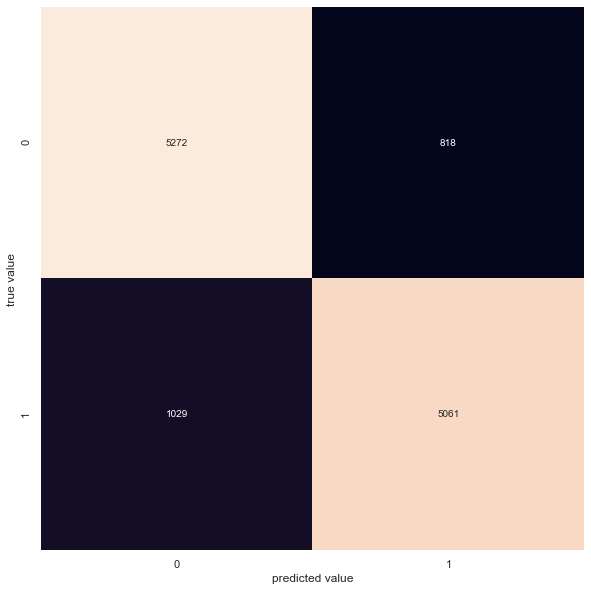

In [ ]:
y_true = test_df['toxic']
y_pred = grid.best_estimator_.predict(test_df['comment_text'])

fig, ax = plt.subplots(1, figsize=(10, 10))

mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False, ax=ax, fmt='g') 
plt.xlabel('predicted value')
plt.ylabel('true value');

In [ ]:
from sklearn.metrics import classification_report

target_names = ['Non-Toxic', 'Toxic']

print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Non-Toxic       0.84      0.87      0.85      6090
       Toxic       0.86      0.83      0.85      6090

    accuracy                           0.85     12180
   macro avg       0.85      0.85      0.85     12180
weighted avg       0.85      0.85      0.85     12180



In [ ]:
y_true = test_df['toxic']
y_pred = grid.best_estimator_.predict(test_df['comment_text'])

fig, ax = plt.subplots(1, figsize=(10, 10))

mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False, ax=ax, fmt='g') 
plt.xlabel('predicted value')
plt.ylabel('true value');

In [ ]:
grid.best_estimator_.score(test_df['comment_text'], test_df['toxic']) 

0.8483579638752052